In [ ]:
from triqs.gf import *
from triqs.gf.tools import fit_legendre
import triqs.utility.mpi as mpi
from triqs.operators import *
from triqs_cthyb import Solver
from h5 import *
import numpy as np
import sys
%matplotlib inline
from triqs.plot.mpl_interface import plt,oplot

In [ ]:
def mpi_print(arg):
    if mpi.is_master_node():
        print(arg)

If not created, you should create a directory name results_tutorial

## Attractive Hubbard Model

Superconductivity can be described using the Hubbard model, similarly to what we did with the Mott insulator in previous tutorials. When looking at the phase diagram for this model we can see that the superconducting and antiferromagnetic states are completly symmetrical around the temperature (T) axis. 

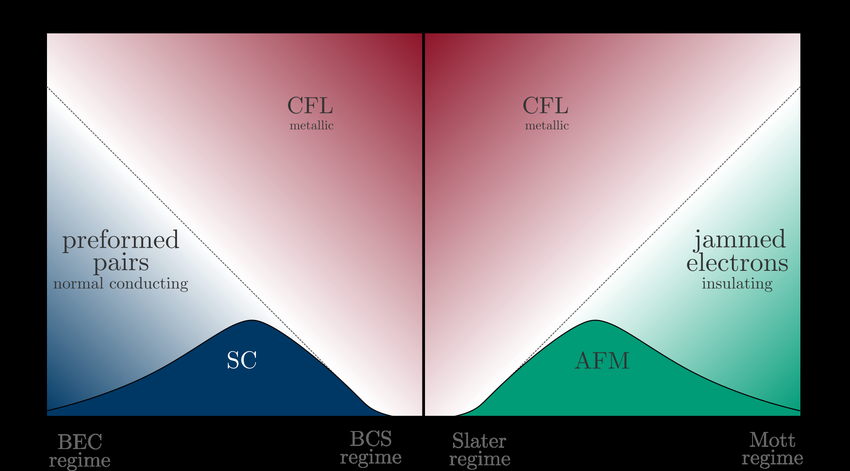!

https://www.researchgate.net/figure/Equilibrium-phase-diagram-of-the-three-dimensional-Hubbard-model-on-cubic-lattice-as-a_fig8_358145714

With the x-axis being U. The Hamiltonian of the Hubbard model at half filling is described by:

$$
H_U=-t\sum_{\langle ij\sigma \rangle} c_{i \sigma}^\dagger c_{j \sigma} + U(n_\uparrow - 1/2) (n_\downarrow - 1/2)
$$

Where when using a negative U (for superconductivity), states which are filled with electrons($|\uparrow \downarrow \rangle$) and empty states 
 ($|0 \rangle$) minimize the energy. 

In order to solve this Hamiltonian using the same method as for the Mott insulator (cthyb solver), we will use the following mapping:



$$
\begin{cases}
c_\uparrow \rightarrow c_\uparrow &\\
c_\downarrow \rightarrow (-1)^ic_\downarrow^\dagger & 
\end{cases}
$$

$$
H_U \rightarrow H_{-U} \\
$$

In term, we will also get: 

$$
n_\downarrow=c_\downarrow^\dagger c_\downarrow \rightarrow c_\downarrow c_\downarrow^\dagger 
$$
Thus, we can use the same method than for Mott insulators to express superconductivity. 

# Nambu superconductivity model

The Nambu formalism for superconductivity permits the description of superconductivity in a one particle Green's function. To describe superconductivity, one has to be able to consider electron-electron pairs, but also hole-hole and electron-hole pairs. The Nambu spinors that allow such a description are:
$$\psi = \begin{pmatrix}
    c_\uparrow \\
    c_\downarrow^\dagger
\end{pmatrix}
\quad
\psi^\dagger = \begin{pmatrix}
    c_\uparrow^\dagger & c_\downarrow
\end{pmatrix}$$


The Green's function in the Nambu formalism is thus:
$$G = - \langle T_\tau c(\tau)c^\dagger \rangle   \rightarrow -\langle T_\tau \psi(\tau) \psi^\dagger \rangle$$    
$$
G = - \langle T \begin{pmatrix}
    c_{\uparrow} (\tau) c_{\uparrow}^\dagger & c_\downarrow (\tau) c_\uparrow \\
    c_\uparrow^\dagger (\tau) c_\downarrow^\dagger & c_\downarrow^\dagger (\tau) c_\downarrow 
\end{pmatrix} \rangle =  \langle \begin{pmatrix}
    g(\tau) & F(\tau) \\
    F(\tau)* & -g(-\tau) 
\end{pmatrix} \rangle
$$

As expected, the Green's function is hermitian. For any classical situation, we would expect the $\langle F(\tau) \rangle$ to be null however, since superconductivity does not conserve the number of particles, we suppose $F(\tau)$ will be non-zero for a superconducting state. To stimulate the apparition of superconductivity under critical T we should off-start the Green's function with a very small $\Delta_0$ in the off-diagonal term of the Green's function. If we set the system over critical T the terms should evolve toward 0.


To keep up with the matrix form of the Nambu formalism,  the Weiss field can be written as:

$$
{\cal G}_{0}^{-1} (i\omega_n) = i\omega_n  + \mu \sigma_3 - t^2 \sigma_3 G_{ \sigma} (i\omega_n) \sigma_3
$$

Where $\sigma_3$ is the Pauli matrice $ \begin{pmatrix}
    1 & 0 \\
    0 & -1
\end{pmatrix}$

For more information refer to: Georges, Antoine, Gabriel Kotliar, Werner Krauth, and Marcelo J. Rozenberg. “Dynamical Mean-Field Theory of Strongly Correlated Fermion Systems and the Limit of Infinite Dimensions.” Reviews of Modern Physics 68, no. 1 (January 1, 1996): 13–125. https://doi.org/10.1103/RevModPhys.68.13.

# Suplementary Details: Charge Density Waves vs Superconductivity

2 degenerate states can be the ground state of our Hamiltonian. The superconducting state (SC), which is described by a superposition of empty and full states:

$$
|SC \rangle = \frac{1}{\sqrt{2}}(|0 \rangle + |\uparrow \downarrow \rangle)_i \hspace{5mm} \forall \hspace{3mm} i
$$

And the charge density wave state (CDW), which is described by a lattice with half the sites full and half the sites empty.

$$
|CDW \rangle =\begin{cases}
|0\rangle, & \text{sites A}\\
|\uparrow \downarrow \rangle, & \text{sites B}
\end{cases}
$$

When trying to solve the Hamiltonian, those two states will compete with each other. To encourage the apparition of a superconducting state, we consider a very high mixing that will break the structure of the Green function in the lattice for CDW by mixing most of the new structures of each iteration with some of the old structures from prior iterations.


### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 1:
Finish the Nambu superconductivity model below to obtain the Green function. Plot an example of a Green's function.

In [ ]:
def DMFT(beta,U,n_cycles=10000,own_path="",niter0=0,niter=30,D0=0.005):
    
    n_iw = int(15*beta)
    n_tau = int(100*beta)

    mixing=0.7
    mu = 0 
    Delta0=D0
    t=1
    # Interacting Hamiltonian in the Nambu basis
    h_int = U * (n('N', 0)-1/2) * (c('N', 1)*c_dag('N', 1) - 1/2)
    p = {'n_warmup_cycles': 3000,#int(4000*beta),  #5000
                 'n_cycles': n_cycles,#int(nc*np.abs(U)*beta/mpi.size)
                 'random_seed': 123 * mpi.rank + 321,
                 'length_cycle': int(20*beta),
                 'measure_G_tau': True,
                 'use_norm_as_weight': True,
                 'imag_threshold': 1e-11,
        }
    mpi_print("U = %.2f, Beta = %i" % (U, beta))

    
    S = Solver(beta = beta, n_iw = n_iw, n_tau = n_tau, gf_struct = [('N', 2)])    


    ###################################### Break the symmetry ##################################################3
    # Symmetry breaking field
    Sigma = S.G0_iw['N'].copy()
    Sigma.zero()
    Sigma[0, 1] << Delta0
    Sigma[1, 0] << Delta0

    ########################################### Finish the code ###################################################################
    # SemiCircular DOS
    S.G0_iw['N'][0, 0] << SemiCircular(2*t)
    S.G0_iw['N'][1, 1] = S.G0_iw['N'][0, 0].copy()
    S.G0_iw['N'][1, 1] << -1 * S.G0_iw['N'][1, 1].conjugate()

    # Inversion of the Green function
    S.G_iw['N'] << inverse(inverse(S.G0_iw['N']) - Sigma)
    
    if own_path=="":
        path=f"U{U}_b{beta}_2eSC"
    else:
        path=own_path

    for i in range(niter0, niter):
        mpi_print("#####  U = %.2f ##### Beta = %.2f ##### Iteration = %i" % (U,beta, i))
        sys.stdout.flush()
      
          # Self-consistency relation
        S.G0_iw['N'][0, 0] << iOmega_n + mu - t**2 * S.G_iw['N'][0, 0]
        S.G0_iw['N'][0, 1] << + t**2 * S.G_iw['N'][0, 1]
        S.G0_iw['N'][1, 0] << + t**2 * S.G_iw['N'][1, 0]
        S.G0_iw['N'][1, 1] << iOmega_n - mu - t**2 * S.G_iw['N'][1, 1]
        S.G0_iw['N'].invert()
        
         # Save an older Green function for mixing after solve.
        old_G_iw = S.G_iw.copy()
        old_Sigma = S.Sigma_iw.copy()['N']
        S.solve(h_int = h_int, **p)

        # Mixing to avoid density fluctuations
        S.G_iw << mixing*S.G_iw + (1-mixing)*old_G_iw


        if mpi.is_master_node():
            with HDFArchive(f"results_tutorial/{path}.h5", 'a') as arch: arch[f"Solver-iter{i}"] = S 
        
    return 

In [ ]:
betas=[9]
U=-4
niter=30
niter0=0
for beta in betas:
    DMFT(beta=beta,U=U, niter=niter)


for beta in betas:
    y=[]
    path=f"U{U}_b{beta}_2eSC"
    for i in range(niter0,niter):
        with HDFArchive(f"results_tutorial/{path}.h5","r") as R:
            S = R[f"Solver-iter29"]
        

    plt.figure(figsize=(8, 6))

    plt.subplot(2, 2, 1)  # (rows, columns, panel number)
    oplot(S.G_tau['N'][0,0])
    plt.subplot(2, 2, 2)  # (rows, columns, panel number)
    oplot(S.G_tau['N'][1,0])
    plt.subplot(2, 2, 3)  # (rows, columns, panel number)
    oplot(S.G_tau['N'][0,1])
    plt.subplot(2, 2, 4)  # (rows, columns, panel number)
    oplot(S.G_tau['N'][1,1])
    
    
    
    plt.tight_layout()

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 2:

Now create a plot of $F(\tau=0)$ with regards to iterations for many different temperatures (do a semilog plot). For what temperature is the model superconductor? What is the cutoff?

In [ ]:
betas=[3,4,5,6,7,8]
U=-4
niter=30
niter0=0
for beta in betas:
    DMFT(beta=beta,U=U, niter=niter)   #We create the data

for beta in betas:    #We plot the data
    y=[]
    path=f"U{U}_b{beta}_2eSC"
    for i in range(niter0,niter):
        with HDFArchive(f"results_tutorial/{path}.h5","r") as R:
            S_ = R[f"Solver-iter{i}"]
        y+=[S_.G_tau['N'][1,0][Idx(0)]]
    plt.semilogy(np.arange(niter0,niter,1),abs(np.array(y)),label=rf'$\beta$={beta},U={U}',linestyle='-',marker='o',markersize=5)
    
plt.xlabel('iteration')
plt.ylabel(r'|$F(\tau=0)$|')
plt.legend(loc='best')


If $F(\tau=0)$ is converging to a value, it is a superconducting state. If it goes to 0, superconductivity was not reach. The temperature at which the $F(\tau=0)$ creates a plateau (here $\beta=5$) corresponds to the critical temperature.

### <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise 3:

Now verify the impact of multiple U on the critical temperature for superconductivity. Plot  $F(\tau=0)$ as a function of T for different U for your last iteration.

In [ ]:
Us=[-3,-4,-5]
betas=[4.5,5,5.5,6,6.5,7,7.5]
niter=20
for U in Us:
    for beta in betas:
        path=f"h5_U{U}_b{beta}"
        DMFT(beta=beta,U=U, niter=niter,own_path=path,D0=0.05)

for U in Us:
    y2=[]
    for beta in betas:
   
        path=f"h5_U{U}_b{beta}"
        
        with HDFArchive(f"results_tutorial/{path}.h5","r") as R:
            S = R[f"Solver-iter{niter-1}"]
        y2+=[S.G_tau['N'][1,0][Idx(0)]]
    plt.plot(1/np.array(betas),-1*np.array(y2),marker='o',label=f'U={U}')
    
plt.xlabel('T')
plt.ylabel(r'|$F(\tau=0)$|')
plt.legend(loc='best')

Superconductivity is reached when $F(\tau=0)$ is non zero. U=-4 is optimal to obtain superconductivity as it has the highest critical temperature. If the U parameter is changed, then the critical temperature for superconductivity is also changed. 